In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Tạo bộ tăng cường dữ liệu (data augmentation)
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [3]:
# Áp dụng data augmentation cho tập huấn luyện
train_generator = train_datagen.flow_from_directory(directory="dataset/gender/Training",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Tạo bộ tăng cường dữ liệu cho tập validation (không thay đổi dữ liệu)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Áp dụng data augmentation cho tập validation
validation_generator = validation_datagen.flow_from_directory(directory="dataset/gender/Validation",
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='categorical')

Found 4074 images belonging to 2 classes.
Found 4074 images belonging to 2 classes.


In [9]:
# Khởi tạo mô hình CNN
model = Sequential()

# Các lớp Convolutional
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))) # out = (kichthuocanh - (kernel - 1)) / s
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten
model.add(Flatten())

# Fully-connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(2, activation='softmax'))

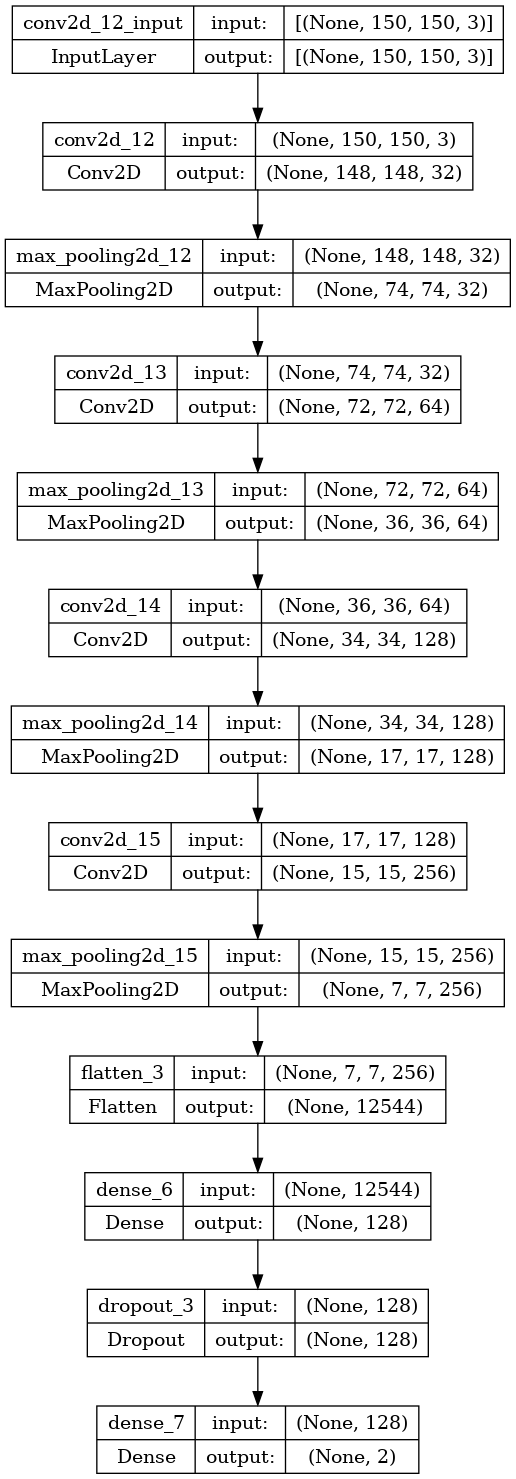

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# Compile mô hình
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Sử dụng EarlyStopping để dừng quá trình huấn luyện sớm nếu không có cải tiến đáng kể
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [12]:
# Huấn luyện mô hình
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[early_stopping])

Epoch 1/20
127/127 [==============================] - 90s 585ms/step - loss: 0.6954 - accuracy: 0.5675 - val_loss: 0.5740 - val_accuracy: 0.7101
Epoch 2/20
127/127 [==============================] - 41s 322ms/step - loss: 0.6044 - accuracy: 0.6809 - val_loss: 0.4600 - val_accuracy: 0.7827
Epoch 3/20
127/127 [==============================] - 41s 320ms/step - loss: 0.5058 - accuracy: 0.7610 - val_loss: 0.3726 - val_accuracy: 0.8307
Epoch 4/20
127/127 [==============================] - 52s 409ms/step - loss: 0.4682 - accuracy: 0.7924 - val_loss: 0.3711 - val_accuracy: 0.8428
Epoch 5/20
127/127 [==============================] - 42s 327ms/step - loss: 0.4300 - accuracy: 0.8065 - val_loss: 0.3020 - val_accuracy: 0.8684
Epoch 6/20
127/127 [==============================] - 42s 329ms/step - loss: 0.4048 - accuracy: 0.8224 - val_loss: 0.2778 - val_accuracy: 0.8912
Epoch 7/20
127/127 [==============================] - 41s 325ms/step - loss: 0.3837 - accuracy: 0.8352 - val_loss: 0.2486 - val_ac

In [13]:
# Đánh giá độ chính xác của mô hình
score = model.evaluate(train_generator,verbose=0)
print('Sai số kiểm tra là: ',score[0])
print('Độ chính xác kiểm tra là: ',score[1])

Sai số kiểm tra là:  0.195728600025177
Độ chính xác kiểm tra là:  0.9189985394477844


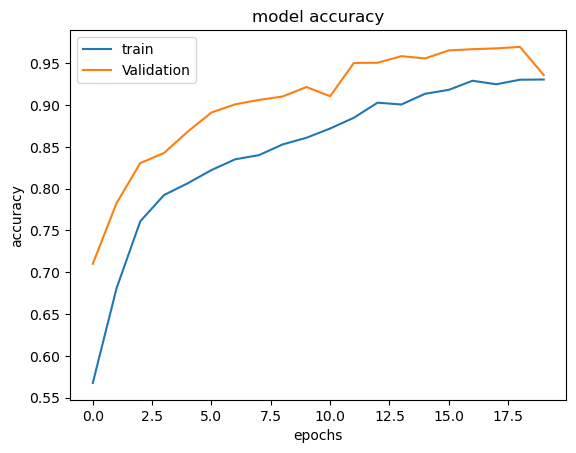

In [14]:
import matplotlib.pyplot as plt
# Draw plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','Validation'])
plt.show()

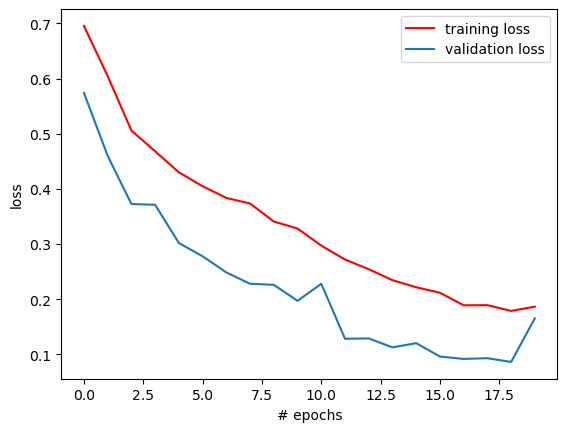

In [15]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
from tensorflow.keras.models import load_model
model.save('Gender2.h5')